# --> Currency exchange Rate Prediction form USD to INR

In [1]:
import pandas as pd
import datetime
from datetime import timedelta, date

In [2]:
def daterange(start_date, end_date):
    for i in range(int((end_date - start_date).days)):
        yield start_date + timedelta(i)

In [3]:
start_date = date(2022, 10, 1)
end_date = datetime.date.today()

In [4]:
df = pd.DataFrame()
for single_date in daterange(start_date, end_date):
    dfs = pd.read_html(f'https://www.xe.com/currencytables/?from=USD&date={single_date.strftime("%Y-%m-%d")}')[0]
    dfs['Date'] = single_date.strftime("%Y-%m-%d")
    df = pd.concat([df, dfs])

df.to_csv('usd_data.csv')

In [5]:
inr_df = df[df['Currency'] == 'INR']

In [6]:
inr_df

,Currency,Name,Units per USD,USD per unit,Date
3,INR,Indian Rupee,81.569652,0.012259,2022-10-01
3,INR,Indian Rupee,81.592623,0.012256,2022-10-02
3,INR,Indian Rupee,81.564234,0.012260,2022-10-03
3,INR,Indian Rupee,81.451499,0.012277,2022-10-04
3,INR,Indian Rupee,81.646995,0.012248,2022-10-05
...,...,...,...,...,...
3,INR,Indian Rupee,82.605252,0.012106,2023-02-28
3,INR,Indian Rupee,82.428770,0.012132,2023-03-01
3,INR,Indian Rupee,82.399134,0.012136,2023-03-02
3,INR,Indian Rupee,81.732170,0.012235,2023-03-03


In [7]:
inr_df.to_csv('usd_data_inr.csv')

In [8]:
hist_df = pd.read_csv('usd_data_inr.csv')

<AxesSubplot: xlabel='Date'>

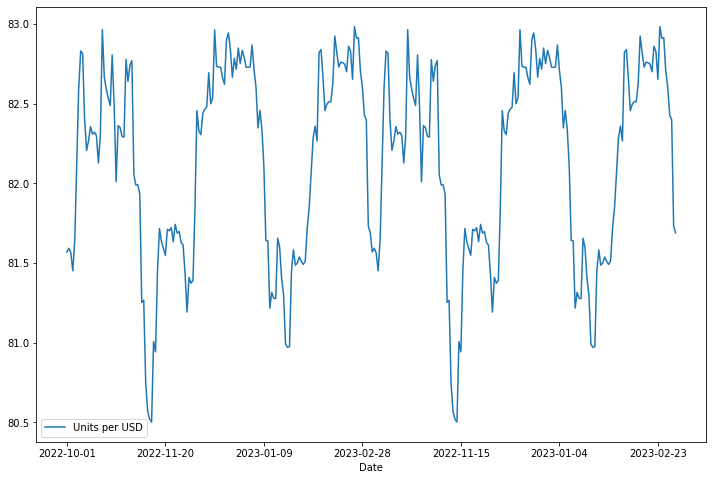

In [9]:
inr_df = pd.concat([hist_df, inr_df], ignore_index=True)
inr_df.plot(x='Date', y='Units per USD', figsize=(12, 8))

In [10]:
inr_df.columns

Index(['Unnamed: 0', 'Currency', 'Name', 'Units per USD', 'USD per unit',
       'Date'],
      dtype='object')

In [11]:
from prophet import Prophet
import plotly.graph_objs as go
import plotly.offline as py
import numpy as np

In [12]:
df = inr_df.drop(['Unnamed: 0', 'Currency', 'Name', 'USD per unit'], axis=1)
df.head()

,Units per USD,Date
0,81.569652,2022-10-01
1,81.592623,2022-10-02
2,81.564234,2022-10-03
3,81.451499,2022-10-04
4,81.646995,2022-10-05


In [13]:
df = df.rename(columns={'Units per USD':'y', 'Date': 'ds'})
df.head()

,y,ds
0,81.569652,2022-10-01
1,81.592623,2022-10-02
2,81.564234,2022-10-03
3,81.451499,2022-10-04
4,81.646995,2022-10-05


In [14]:
df['y_orig'] = df['y']
df['y'] = np.log(df['y'])

In [15]:
model = Prophet()
model.fit(df)

09:48:12 - cmdstanpy - INFO - Chain [1] start processing
09:48:12 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future_data = model.make_future_dataframe(periods=10, freq='D')
# future_data.tail(50)

In [17]:
forecast_data = model.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
160,2023-03-10,4.414778,4.407754,4.421885
161,2023-03-11,4.414890,4.405525,4.423181
162,2023-03-12,4.415463,4.404432,4.426650
163,2023-03-13,4.416793,4.403098,4.431010
164,2023-03-14,4.416424,4.400758,4.431988


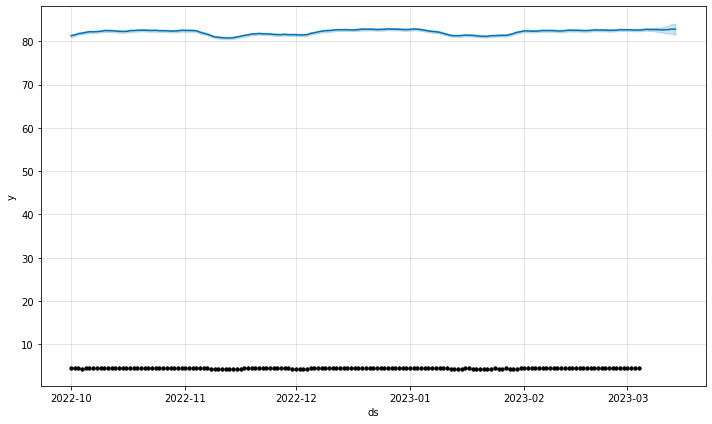

In [18]:
forecast_data_orig = forecast_data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
fig = model.plot(forecast_data_orig)

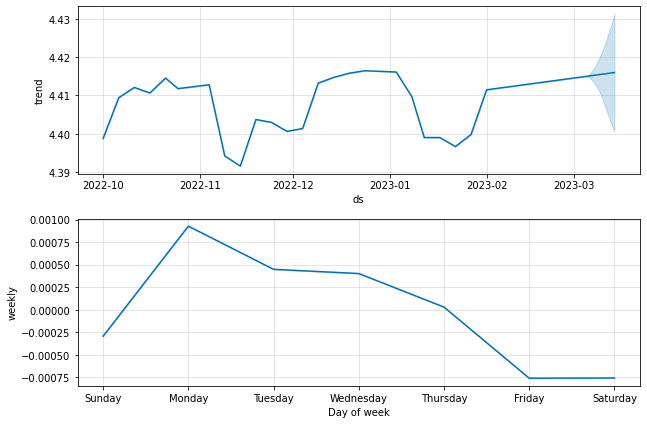

In [19]:
fig2 = model.plot_components(forecast_data_orig)

In [20]:
df['y_log'] = df['y']
df['y'] = df['y_orig']

In [21]:
from prophet.plot import plot_plotly
import plotly.offline as py

In [22]:
final_df = pd.DataFrame(forecast_data_orig)
actual_chart = go.Scatter(y=df['y_orig'], name='Actual')
predict_chart = go.Scatter(y=final_df['yhat'], name='Predicted')
predict_chart_upper = go.Scatter(y=final_df['yhat_upper'], name='Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df['yhat_lower'], name='Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'